In [1]:
import os, getpass
from langchain_groq import ChatGroq

import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

from langchain_groq import ChatGroq
model = ChatGroq(model="openai/gpt-oss-20b")

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import sqlite3
# In memory
conn = sqlite3.connect(":memory:", check_same_thread = False)

In [3]:
# pull file if it doesn't exist and connect to local db
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

A subdirectory or file state_db already exists.
Error occurred while processing: state_db.


In [4]:
# Here is our checkpointer 
from langgraph.checkpoint.sqlite import SqliteSaver
memory = SqliteSaver(conn)

In [6]:
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, RemoveMessage

from langgraph.graph import END
from langgraph.graph import MessagesState

model = ChatGroq(model="openai/gpt-oss-20b")

class State(MessagesState):
    summary: str

# Define the logic to call the model
def call_model(state: State):
    
    # Get summary if it exists
    summary = state.get("summary", "")

    # If there is summary, then we add it
    if summary:
        
        # Add summary to system message
        system_message = f"Summary of conversation earlier: {summary}"

        # Append summary to any newer messages
        messages = [SystemMessage(content=system_message)] + state["messages"]
    
    else:
        messages = state["messages"]
    
    response = model.invoke(messages)
    return {"messages": response}

def summarize_conversation(state: State):
    
    # First, we get any existing summary
    summary = state.get("summary", "")

    # Create our summarization prompt 
    if summary:
        
        # A summary already exists
        summary_message = (
            f"This is summary of the conversation to date: {summary}\n\n"
            "Extend the summary by taking into account the new messages above:"
        )
        
    else:
        summary_message = "Create a summary of the conversation above:"

    # Add prompt to our history
    messages = state["messages"] + [HumanMessage(content=summary_message)]
    response = model.invoke(messages)
    
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

# Determine whether to end or summarize the conversation
def should_continue(state: State):
    
    """Return the next node to execute."""
    
    messages = state["messages"]
    
    # If there are more than six messages, then we summarize the conversation
    if len(messages) > 6:
        return "summarize_conversation"
    
    # Otherwise we can just end
    return END

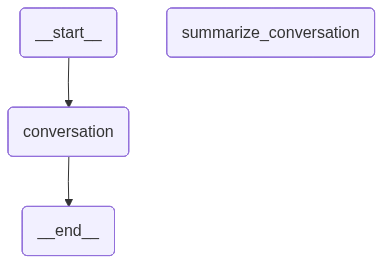

In [7]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START

# Define a new graph
workflow = StateGraph(State)
workflow.add_node("conversation", call_model)
workflow.add_node(summarize_conversation)

# Set the entrypoint as conversation
workflow.add_edge(START, "conversation")
workflow.add_conditional_edges("conversation", should_continue)
workflow.add_edge("summarize_conversation", END)

# Compile
graph = workflow.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}

# Start conversation
input_message = HumanMessage(content="hi! I'm Rao")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="what's my name?")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

input_message = HumanMessage(content="i like football!")
output = graph.invoke({"messages": [input_message]}, config) 
for m in output['messages'][-1:]:
    m.pretty_print()

================================== Ai Message ==================================

Hey Rao! 👋 Great to see you back. You mentioned you’re into football—anything in particular you’re excited about right now? Whether it’s the NFL, college gridiron, or the global soccer scene, I’m all ears for a deep dive or just a casual chat!
================================== Ai Message ==================================

Your name is Rao.
================================== Ai Message ==================================

That’s awesome, Rao! ⚽️🏈 Which side of the game gets your heart racing? Are you more into the NFL, college football, or the global soccer (football) scene? Let me know and we can dive into the latest news, stats, or even a quick trivia quiz!


In [9]:
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Rao", additional_kwargs={}, response_metadata={}, id='0b2abdc8-2ef9-452b-85d5-55d0172e23d0'), AIMessage(content='Hey Rao! 👋 Great to see you back. You mentioned you’re into football—anything in particular you’re excited about right now? Whether it’s the NFL, college gridiron, or the global soccer scene, I’m all ears for a deep dive or just a casual chat!', additional_kwargs={'reasoning_content': 'User says hi again. We should respond warmly, maybe ask about football. They already said they like football. They might want to continue conversation. We can ask what they like about football. Also maybe ask if they want to talk about a specific league. So respond friendly.'}, response_metadata={'token_usage': {'completion_tokens': 123, 'prompt_tokens': 1107, 'total_tokens': 1230, 'completion_time': 0.125389402, 'prompt_time': 0.068791816, 'queue_time': 0.051074874, 'total_time': 0.194181218}, 'model_name': 'openai/gpt-oss-20b',

In [10]:
# Create a thread
config = {"configurable": {"thread_id": "1"}}
graph_state = graph.get_state(config)
graph_state

StateSnapshot(values={'messages': [HumanMessage(content="hi! I'm Rao", additional_kwargs={}, response_metadata={}, id='0b2abdc8-2ef9-452b-85d5-55d0172e23d0'), AIMessage(content='Hey Rao! 👋 Great to see you back. You mentioned you’re into football—anything in particular you’re excited about right now? Whether it’s the NFL, college gridiron, or the global soccer scene, I’m all ears for a deep dive or just a casual chat!', additional_kwargs={'reasoning_content': 'User says hi again. We should respond warmly, maybe ask about football. They already said they like football. They might want to continue conversation. We can ask what they like about football. Also maybe ask if they want to talk about a specific league. So respond friendly.'}, response_metadata={'token_usage': {'completion_tokens': 123, 'prompt_tokens': 1107, 'total_tokens': 1230, 'completion_time': 0.125389402, 'prompt_time': 0.068791816, 'queue_time': 0.051074874, 'total_time': 0.194181218}, 'model_name': 'openai/gpt-oss-20b',